In [98]:
# importing dependencies
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [55]:
# get subsets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [56]:
# checking the subsets
print(X_train.shape) 
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [57]:
# flattening the subsets
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

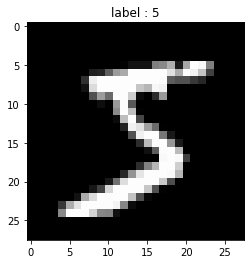

In [58]:
# visualize the data
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [59]:
# pre processing
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min())

1.0
0.0


In [60]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [61]:
# splitting our subsets into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [62]:
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [63]:
# mini batch
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [64]:
# calculating the batch
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

In [65]:
print(len(get_mini_batch))

2400


[Problem 1] Creating a code to determine the initial weight value

In [66]:
n_sample,n_features = X_train.shape
n_nodes1 = 400
sigma = 0.01 # Standard deviation of Gaussian distribution
W1 = sigma * np.random.randn(n_features, n_nodes1)

In [67]:
print(n_nodes1)

400


In [172]:
# neural network from scratch
class ScratchSimpleNeuralNetrowkClassifier():

    def __init__(self, verbose = True, n_features=784,n_nodes1=400,n_nodes2=200, batch_size=20,n_output=10, n_epoch=10, lr=0.5, sigma=0.01):
        self.verbose = verbose
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.batch_size = batch_size
        self.n_output = n_output
        self.n_epoch = 30
        self.lr = lr
        self.sigma = sigma
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.W3 = None
        self.b3 = None
        self.loss = []
        self.val_loss = []
        pass
    
    def fit(self, X, y, X_val=None, y_val=None):
      self.create_init_w_b()
      for epoch in range(self.n_epoch):
          get_mini_batch = GetMiniBatch(X, y, self.batch_size)
          for mini_X_train, mini_y_train in get_mini_batch:    
            # forward propagation
            self.forward_propagation(mini_X_train)
            self.back_propagation(mini_X_train, mini_y_train)

          self.forward_propagation(X)
          # self.loss.append(self.cross_entropy_error(y, self.layer_3))
          # if X_val is not None:
          #     self.forward(X_val)
          #     self.loss_test.append(self.cross_entropy_error(y_val, self.layer_3))

      if self.verbose:
          # When verbose is set to True, the learning process etc. is output.
          print(self.loss)
      pass
    
    def create_init_w_b(self):
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.b1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.b2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.b3 = self.sigma * np.random.randn(1, self.n_output)
    
    def activation_function(self,X, layer):
      if layer == "hidden" or layer == "first":
        act_f = np.tanh(X)
        return act_f
      else: 
        act_f = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
        return act_f

    def cross_entropy_error(self, y, layer):
        e = - np.sum(y * np.log(layer)) / len(y)
        return e

    def forward_propagation(self,X):
        layer_1_pre = np.dot(X,self.W1) + self.b1
        self.layer_1 = self.activation_function(layer_1_pre, "first")

        layer_2_pre = np.dot(self.layer_1,self.W2) + self.b2
        self.layer_2 = self.activation_function(layer_2_pre, "hidden")

        layer_3_pre = np.dot(self.layer_2,self.W3) + self.b3
        self.layer_3 = self.activation_function(layer_3_pre, "output")
        
    def back_propagation(self, X, y):

      delta_3 = self.layer_3 - y
      self.W3 += -self.lr*np.transpose(self.layer_2)@delta_3
      self.b3 += -self.lr*np.sum(delta_3)

      delta_2 = delta_3@np.transpose(self.W3)*(self.layer_2 * (1 - self.layer_2))
      self.W2 += -self.lr*np.transpose(self.layer_1)@delta_2
      self.b2 += -self.lr*np.sum(delta_2)

      delta_1 = delta_2@np.transpose(self.W2)*(self.layer_1 * (1 - self.layer_1))
      self.W1 += -self.lr*np.transpose(X)@delta_1
      self.b1 += -self.lr*np.sum(delta_1)

    def predict(self, X):
      self.forward_propagation(X)
      return np.argmax(self.layer_3, axis=1)

In [173]:
model = ScratchSimpleNeuralNetrowkClassifier()
model.fit(X_train,y_train_one_hot,X_val,y_test_one_hot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


[]


In [169]:
y_pred = model.predict(X_val)
print(y_pred)

[0 0 0 ... 0 0 0]


In [171]:
accuracy_score(y_val, y_pred)

0.10291666666666667